In [16]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import os
import glob
from scipy import stats
import re
import datetime
from scipy.interpolate import griddata
%matplotlib inline

In [17]:
dir_in = '/p/scratch/cjibg36/kaandorp2/'

grid_dest = xr.load_dataset( os.path.join(dir_in,'TSMP/setup_clm_cordex_109x106/inputdata/griddata_cordex_109x106.nc') )
folder_data_in = os.path.join(dir_in, 'data/ERA5_BC/')
folder_data_out = os.path.join(dir_in, 'TSMP/setup_clm_cordex_109x106/atmforcings_nanocean/')
grid_dest

if not os.path.exists(folder_data_out):
    os.mkdir(folder_data_out)

In [19]:
# Interpolation method
method_interp = 'nearest'

# Variables: ERA5 names (in), and required CLM names (out) 
vars_in = ['Tair','PSurf','Qair','Rainf','SWdown','LWdown','Wind']
vars_out = ['TBOT','PSRF','QBOT','PRECTmms','FSDS','FLDS','WIND']

# Variables to copy from the CLM griddata file
vars_copy = ['LATIXY','LONGXY','LONE','LONW','LATS','LATN','EDGEE','EDGES','EDGEW','EDGEN']

# Years/months for which the data are available
years = ['2010']
months = ['%02d' % int_ for int_ in range(1,13)][0:1]

use_mask_out = True # True: keep NaN's in data; False: fill NaN's with interpolation

for year_ in years:
    for month_ in months:
        
        # initialize output dataset by copying the griddata file
        data_out = grid_dest.copy()
        data_out = data_out.drop_vars(['LANDMASK','AREA'])
        
        for i2,(v_in, v_out) in enumerate(zip(vars_in,vars_out)):
            print(v_in,v_out)
            filename = v_in + '*' + year_ + month_ + '*'
            file_in = glob.glob(os.path.join( folder_data_in, filename))[0]
            
            data_in = xr.load_dataset( file_in )
            if i2 == 0:
                data_out['time'] = data_in['time'].copy()
        
            X,Y = np.meshgrid(data_in['lon'],data_in['lat'])
        
            data_out_var = np.zeros([len(data_in[v_in]['time']),grid_dest['LANDMASK'].shape[0],grid_dest['LANDMASK'].shape[1]])
        
            for i1,time_ in enumerate(data_in[v_in]['time']):
                if i1 % 100 == 0:
                    print('%i / %i' % (i1, len(data_in[v_in]['time'])) )
            
                mask_in = ~np.isnan(data_in[v_in][i1,:,:])
                if use_mask_out:
                    mask_out = (grid_dest['LANDMASK'] == 1)
                else:
                    mask_out = np.ones(grid_dest['LANDMASK'].shape,dtype=bool)

                #-------------------- interpolation routine --------------------
                # should be changed to ESMF for conservative interpolation
                data_interp = griddata((X[mask_in],Y[mask_in]),
                                        data_in[v_in][i1,:,:].values[mask_in],
                                        (data_out['LONGXY'].values[mask_out],data_out['LATIXY'].values[mask_out]),
                                        method=method_interp)
                
                data_i_out = np.nan*np.zeros(mask_out.shape)
                data_i_out[mask_out] = data_interp
                #-------------------- /interpolation routine --------------------

                # add interpolated data to array
                data_out_var[i1,:,:] = data_i_out
            
            # put array in data_out
            data_out[v_out] = (['time','lat','lon'], data_out_var)



Tair TBOT
0 / 744
100 / 744
200 / 744
300 / 744
400 / 744
500 / 744
600 / 744
700 / 744
PSurf PSRF
0 / 744
100 / 744
200 / 744
300 / 744
400 / 744
500 / 744
600 / 744
700 / 744
Qair QBOT
0 / 744
100 / 744


KeyboardInterrupt: 

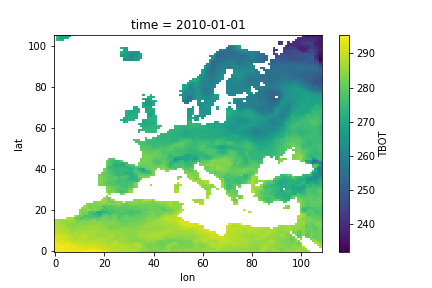

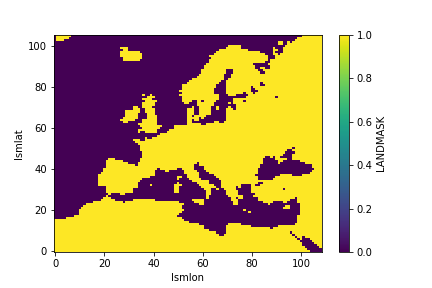

In [21]:
%matplotlib widget
plt.figure()
data_out.TBOT[0].plot.pcolormesh()

plt.figure()
grid_dest.LANDMASK.plot.pcolormesh()

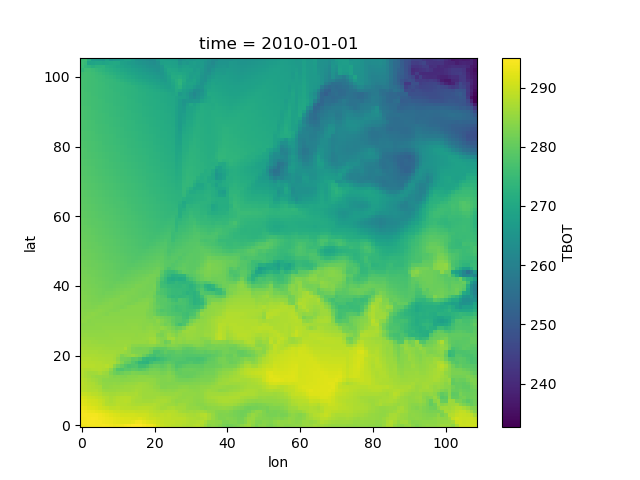

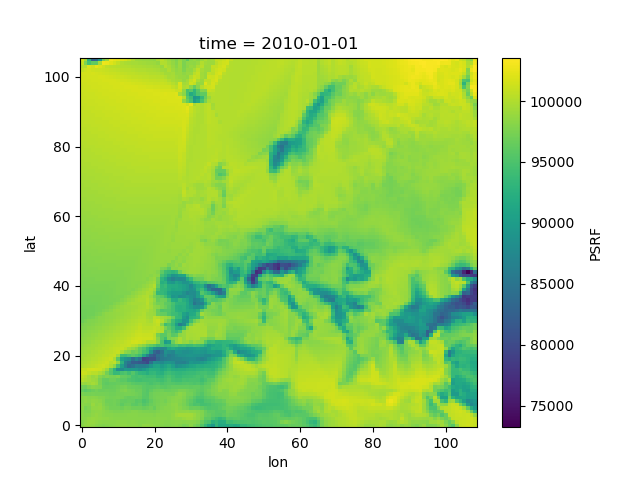

In [115]:
plt.figure()
data_out.TBOT[0].plot.pcolormesh()

plt.figure()
data_out.PSRF[0].plot.pcolormesh()

data_out = grid_dest.copy()

data_out = data_out.drop_vars(['LANDMASK','AREA'])

# filename_out = year_+'-'+month_+'.nc'
# data_out.to_netcdf( os.path.join(folder_data_out,filename_out) )

In [120]:
data_out.attrs

<xarray.Dataset>
Dimensions:  (time: 744, lon: 720, lat: 360)
Coordinates:
  * time     (time) datetime64[ns] 2010-01-01 ... 2010-01-31T23:00:00
  * lon      (lon) float64 -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
  * lat      (lat) float64 -89.75 -89.25 -88.75 -88.25 ... 88.75 89.25 89.75
Data variables:
    PSurf    (time, lat, lon) float32 6.751e+04 6.751e+04 6.753e+04 ... nan nan
Attributes:
    title:        WATCH Forcing Data methodology applied to ERA5 data
    institution:  Copernicus Climate Change Service
    contact:      http://copernicus-support.ecmwf.int
    comment:      Methodology implementation for ERA5 and dataset production ...
    Conventions:  CF-1.7
    summary:      ERA5 data regridded to half degree regular lat-lon; Genuine...
    reference:    Cucchi et al., 2020, Earth Syst. Sci. Data, 12(3), 2097–212...
    licence:      The dataset is distributed under the Licence to Use Coperni...

In [125]:
data_out.attrs['title'] = 'Regridded bias-corrected ERA5 data'
data_out.attrs['source_file'] = 'regridded by m.kaandorp, source data: 10.24381/cds.20d54e34'
data_out.attrs['creation_date'] = str(datetime.datetime.now())

data_out.attrs

{'creation_date': '2023-02-06 16:02:15.553366',
 'Conventions': 'None',
 'source_file': 'regridded by m.kaandorp, source data: 10.24381/cds.20d54e34',
 'title': 'Regridded bias-corrected ERA5 data'}

In [41]:
v_in = 'Wind'
data_in[v_in]

use_mask_out = False # if True, ocean values are set to NaN. If False, interpolation is used to fill the values
X,Y = np.meshgrid(data_in['lon'],data_in['lat'])

for i1,time_ in enumerate(data_in[v_in]['time']):
    
    mask_in = ~np.isnan(data_in[v_in][i1,:,:])
    if use_mask_out:
        mask_out = (grid_dest['LANDMASK'] == 1)
    else:
        mask_out = np.ones(grid_dest['LANDMASK'].shape,dtype=bool)
    
    data_interp = griddata((X[mask_in],Y[mask_in]),
                            data_in[v_in][0,:,:].values[mask_in],
                            (data_out['LONGXY'].values[mask_out],data_out['LATIXY'].values[mask_out]),
                            method='linear')
    data_i_out = np.nan*np.zeros(mask_out.shape)
    data_i_out[mask_out] = data_interp
    

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

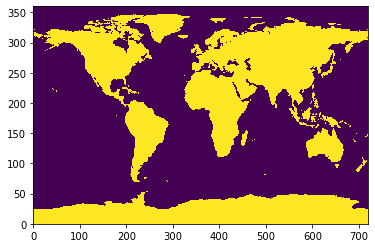

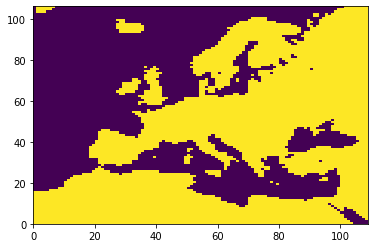

In [43]:
plt.figure()
plt.pcolormesh(mask_in)
plt.figure()
plt.pcolormesh(mask_out)
np.ones(grid_dest['LANDMASK'].shape,dtype=bool)

In [50]:
data_in[v_in][0,:,:].values[mask_in].shape
X[mask_in].shape
mask_out = (grid_dest['LANDMASK'] == 1)
data_out['LATIXY'].values[mask_out].shape
# data_in['Wind']['time']


(6269,)

In [85]:
i1 = 0
data_interp = griddata((X[mask_in],Y[mask_in]),
                        data_in[v_in][0,:,:].values[mask_in],
                        (data_out['LONGXY'].values[mask_out],data_out['LATIXY'].values[mask_out]),
                        method='linear')
data_i_out = np.nan*np.zeros(mask_out.shape)
data_i_out[mask_out] = data_interp

In [162]:
%matplotlib widget
data_ERA = xr.load_dataset('/p/scratch/cjibg36/kaandorp2/data/ERA5_BC/SWdown_WFDE5_CRU_201005_v2.1.nc')

data_i = xr.load_dataset('/p/scratch/cjibg36/kaandorp2/TSMP/tsmp_cordex_109x106/input_atm/2010-05.nc')

data_i

<xarray.Dataset>
Dimensions:   (lsmlat: 106, lsmlon: 109, ncl2: 1, ncl3: 1, ncl4: 1, ncl5: 1, time: 744, lat: 106, lon: 109)
Coordinates:
  * time      (time) datetime64[ns] 2010-05-01 ... 2010-05-31T23:00:00
Dimensions without coordinates: lsmlat, lsmlon, ncl2, ncl3, ncl4, ncl5, lat, lon
Data variables: (12/18)
    NUMLON    (lsmlat) float64 109.0 109.0 109.0 109.0 ... 109.0 109.0 109.0
    LONGXY    (lsmlat, lsmlon) float64 -10.27 -9.874 -9.476 ... 66.04 66.85
    LATIXY    (lsmlat, lsmlon) float64 21.43 21.59 21.75 ... 67.31 67.06 66.81
    LONE      (lsmlat, lsmlon) float64 -10.17 -9.771 -9.372 ... 66.52 67.33
    LATN      (lsmlat, lsmlon) float64 21.62 21.78 21.94 ... 67.38 67.13 66.87
    LONW      (lsmlat, lsmlon) float64 -10.42 -10.03 -9.632 ... 64.35 65.18 66.0
    ...        ...
    PSRF      (time, lat, lon) float64 9.736e+04 9.776e+04 ... 1.005e+05
    SHUM      (time, lat, lon) float64 0.005201 0.004361 ... 0.003525 0.004308
    PRECTmms  (time, lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    FSDS      (time, lat, lon) float64 0.0 0.0 0.0 0.0 ... 88.3 102.0 108.9
    FLDS      (time, lat, lon) float64 379.6 381.0 379.4 ... 270.0 259.4 256.2
    WIND      (time, lat, lon) float64 2.948 4.77 5.167 ... 2.485 1.019 1.633
Attributes:
    creation_date:  2023-02-07 09:53:33.504326
    Conventions:    None
    source_file:    regridded by m.kaandorp, source data doi: 10.24381/cds.20...
    title:          Regridded bias-corrected ERA5 data

In [137]:
data_ERA

<xarray.Dataset>
Dimensions:  (time: 744, lon: 720, lat: 360)
Coordinates:
  * time     (time) datetime64[ns] 2010-05-01 ... 2010-05-31T23:00:00
  * lon      (lon) float64 -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
  * lat      (lat) float64 -89.75 -89.25 -88.75 -88.25 ... 88.75 89.25 89.75
Data variables:
    LWdown   (time, lat, lon) float32 95.76 95.72 95.71 95.66 ... nan nan nan
Attributes:
    title:        WATCH Forcing Data methodology applied to ERA5 data
    institution:  Copernicus Climate Change Service
    contact:      http://copernicus-support.ecmwf.int
    comment:      Methodology implementation for ERA5 and dataset production ...
    Conventions:  CF-1.7
    summary:      ERA5 data regridded to half degree regular lat-lon; Genuine...
    reference:    Cucchi et al., 2020, Earth Syst. Sci. Data, 12(3), 2097–212...
    licence:      The dataset is distributed under the Licence to Use Coperni...

In [148]:
data_i.FSDS[0]

<xarray.DataArray 'FSDS' (lat: 106, lon: 109)>
array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ..., 69.93447113,
        69.92098236, 64.67281342],
       [ 0.        ,  0.        ,  0.        , ..., 55.58732224,
        50.3585701 , 56.39516068],
       [ 0.        ,  0.        ,  0.        , ..., 41.49963379,
        50.49157715, 50.53070068]])
Coordinates:
    time     datetime64[ns] 2010-05-01
Dimensions without coordinates: lat, lon

/tmp/ipykernel_30363/599027568.py:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(X,Y,data_ERA.SWdown[10],vmin=50,vmax=1000)
/tmp/ipykernel_30363/599027568.py:9: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(data_i['LONGXY'],data_i['LATIXY'],data_i.FSDS[10],vmin=50,vmax=1000)


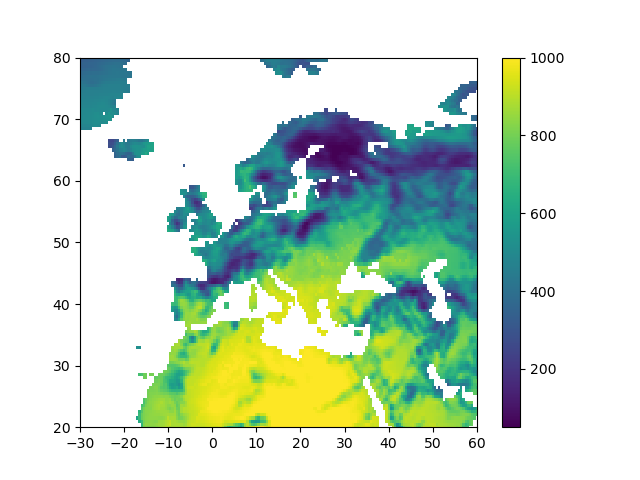

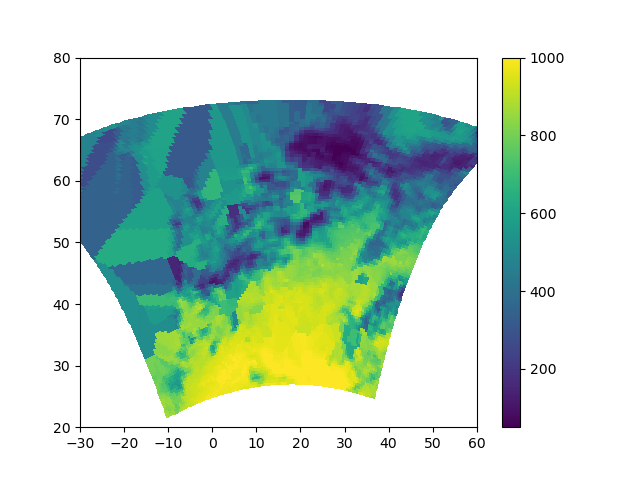

In [166]:
data_ERA = xr.load_dataset('/p/scratch/cjibg36/kaandorp2/data/ERA5_BC/SWdown_WFDE5_CRU_201005_v2.1.nc')
data_i = xr.load_dataset('/p/scratch/cjibg36/kaandorp2/TSMP/tsmp_cordex_109x106/input_atm/2010-05.nc')


X,Y = np.meshgrid(data_ERA['lon'],data_ERA['lat'])
plt.figure()
plt.pcolormesh(X,Y,data_ERA.SWdown[10],vmin=50,vmax=1000)
plt.xlim(-30,60)
plt.ylim(20,80)
plt.colorbar()

plt.figure()
plt.pcolormesh(data_i['LONGXY'],data_i['LATIXY'],data_i.FSDS[10],vmin=50,vmax=1000)
plt.xlim(-30,60)
plt.ylim(20,80)
plt.colorbar()

/tmp/ipykernel_30363/1094517303.py:6: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(X,Y,data_ERA.Wind[10],vmin=0,vmax=15)
/tmp/ipykernel_30363/1094517303.py:12: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(data_i['LONGXY'],data_i['LATIXY'],data_i.WIND[10],vmin=0,vmax=15)


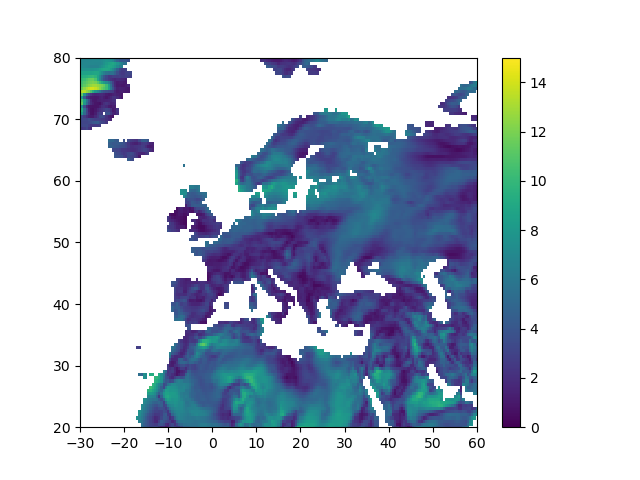

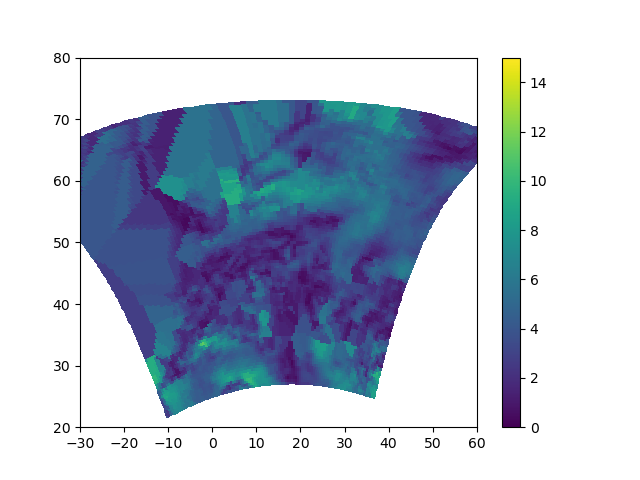

In [168]:
data_ERA = xr.load_dataset('/p/scratch/cjibg36/kaandorp2/data/ERA5_BC/Wind_WFDE5_CRU_201005_v2.1.nc')
data_i = xr.load_dataset('/p/scratch/cjibg36/kaandorp2/TSMP/tsmp_cordex_109x106/input_atm/2010-05.nc')

X,Y = np.meshgrid(data_ERA['lon'],data_ERA['lat'])
plt.figure()
plt.pcolormesh(X,Y,data_ERA.Wind[10],vmin=0,vmax=15)
plt.xlim(-30,60)
plt.ylim(20,80)
plt.colorbar()

plt.figure()
plt.pcolormesh(data_i['LONGXY'],data_i['LATIXY'],data_i.WIND[10],vmin=0,vmax=15)
plt.xlim(-30,60)
plt.ylim(20,80)
plt.colorbar()

In [6]:
data_out = grid_dest.copy()
data_out

data = xr.load_dataset( os.path.join(dir_in,'data/ERA5_BC/Qair_WFDE5_CRU_201001_v2.1.nc') )
data['Qair']

<xarray.DataArray 'Qair' (time: 744, lat: 360, lon: 720)>
array([[[0.00036559, 0.00036561, 0.00036602, ..., 0.00036502,
         0.00036529, 0.00036531],
        [0.00036005, 0.00036012, 0.00036058, ..., 0.00035917,
         0.00035959, 0.00035972],
        [0.00035849, 0.00035881, 0.0003595 , ..., 0.00035703,
         0.00035761, 0.00035794],
        ...,
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]],

       [[0.00036737, 0.00036737, 0.00036777, ..., 0.00036683,
         0.00036708, 0.0003671 ],
        [0.00036271, 0.00036279, 0.00036326, ..., 0.00036188,
         0.00036225, 0.00036239],
        [0.00036004, 0.00036028, 0.00036089, ..., 0.00035886,
         0.00035934, 0.00035958],
...
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]],

       [[0.00034426, 0.00034418, 0.00034449, ..., 0.000344  ,
         0.00034416, 0.0003441 ],
        [0.00033519, 0.00033508, 0.00033535, ..., 0.00033461,
         0.00033493, 0.000335  ],
        [0.0003258 , 0.00032523, 0.00032504, ..., 0.0003259 ,
         0.00032598, 0.00032582],
        ...,
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2010-01-01 ... 2010-01-31T23:00:00
  * lon      (lon) float64 -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
  * lat      (lat) float64 -89.75 -89.25 -88.75 -88.25 ... 88.75 89.25 89.75
Attributes:
    units:          kg kg-1
    long_name:      Near-Surface Specific Humidity
    standard_name:  specific_humidity

In [5]:
atmfiles = glob.glob(os.path.join(folder_data_out,'*'))

In [11]:
data = xr.load_dataset(atmfiles[0])
data

<xarray.Dataset>
Dimensions:   (lsmlat: 106, lsmlon: 109, ncl2: 1, ncl3: 1, ncl4: 1, ncl5: 1, time: 744, lat: 106, lon: 109)
Coordinates:
  * time      (time) datetime64[ns] 2010-03-01 ... 2010-03-31T23:00:00
Dimensions without coordinates: lsmlat, lsmlon, ncl2, ncl3, ncl4, ncl5, lat, lon
Data variables: (12/18)
    NUMLON    (lsmlat) float64 109.0 109.0 109.0 109.0 ... 109.0 109.0 109.0
    LONGXY    (lsmlat, lsmlon) float64 -10.27 -9.874 -9.476 ... 66.04 66.85
    LATIXY    (lsmlat, lsmlon) float64 21.43 21.59 21.75 ... 67.31 67.06 66.81
    LONE      (lsmlat, lsmlon) float64 -10.17 -9.771 -9.372 ... 66.52 67.33
    LATN      (lsmlat, lsmlon) float64 21.62 21.78 21.94 ... 67.38 67.13 66.87
    LONW      (lsmlat, lsmlon) float64 -10.42 -10.03 -9.632 ... 64.35 65.18 66.0
    ...        ...
    PSRF      (time, lat, lon) float64 9.784e+04 9.825e+04 ... 1.015e+05
    SHUM      (time, lat, lon) float64 0.00615 0.006897 ... 0.0004534 0.0007835
    PRECTmms  (time, lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    FSDS      (time, lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    FLDS      (time, lat, lon) float64 350.7 363.6 360.0 ... 185.8 171.5 190.8
    WIND      (time, lat, lon) float64 4.186 4.162 4.248 ... 0.9217 2.231 3.795
Attributes:
    creation_date:  2023-02-07 09:47:28.334037
    Conventions:    None
    source_file:    regridded by m.kaandorp, source data doi: 10.24381/cds.20...
    title:          Regridded bias-corrected ERA5 data

/tmp/ipykernel_12028/901432022.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


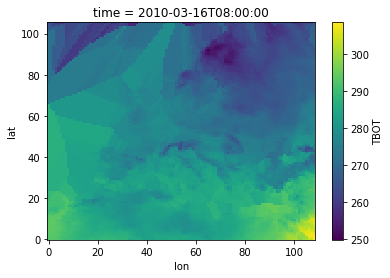

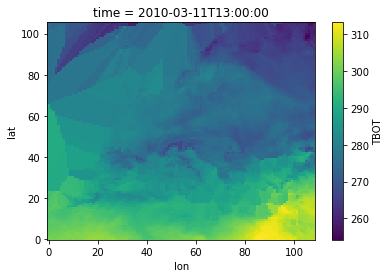

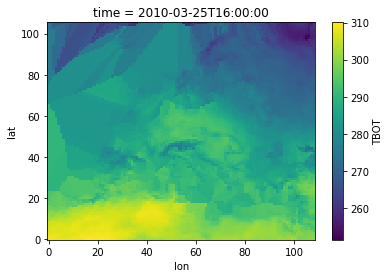

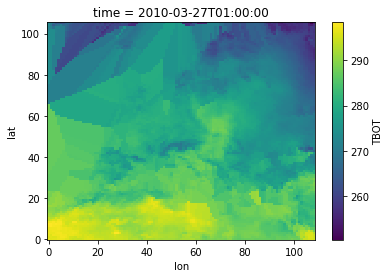

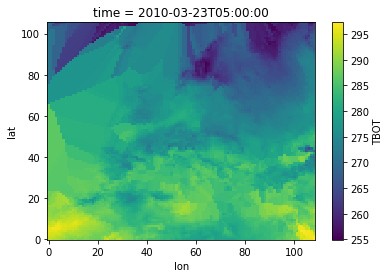

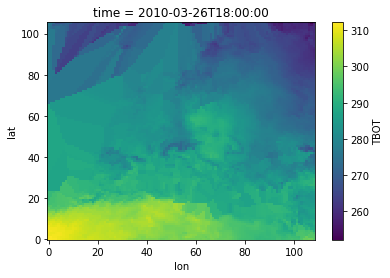

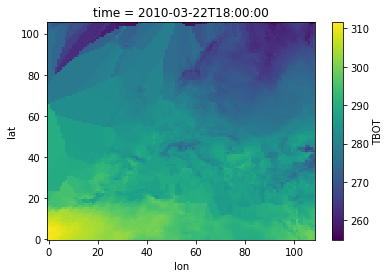

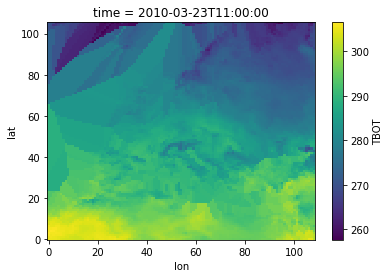

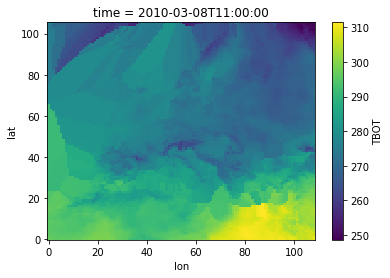

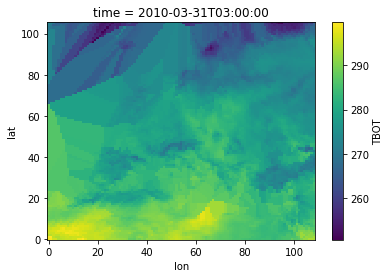

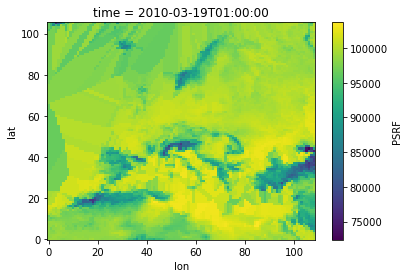

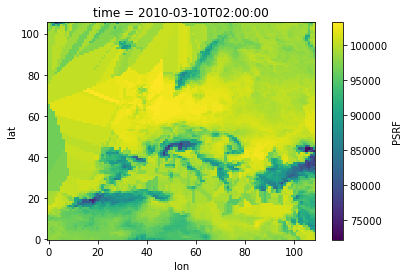

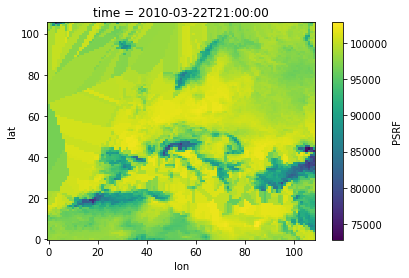

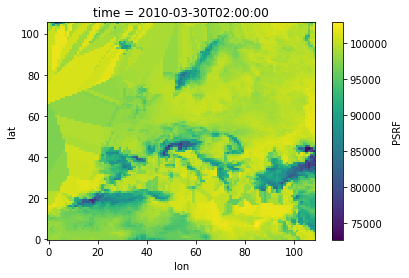

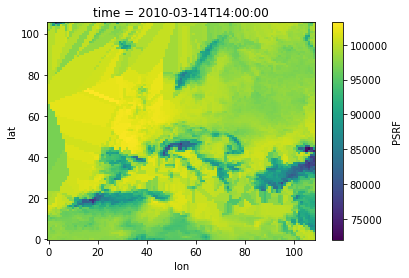

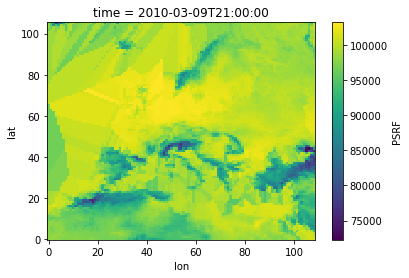

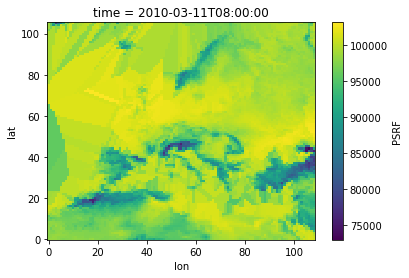

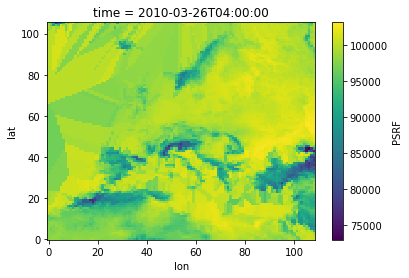

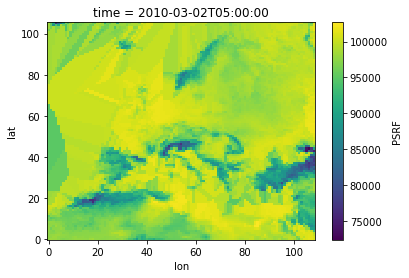

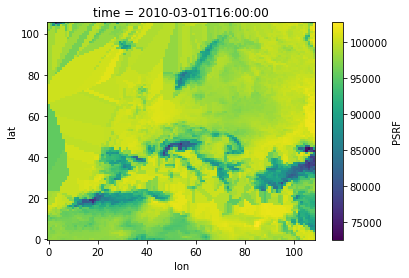

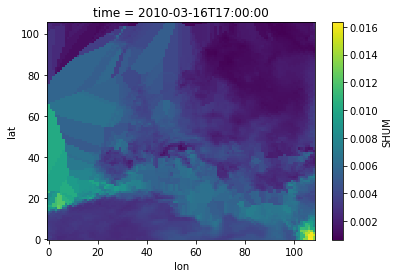

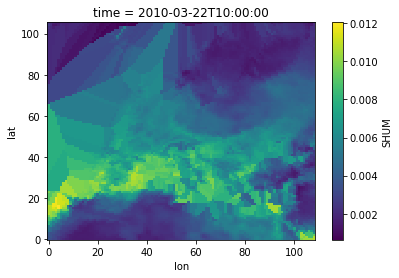

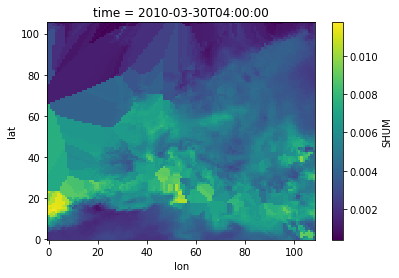

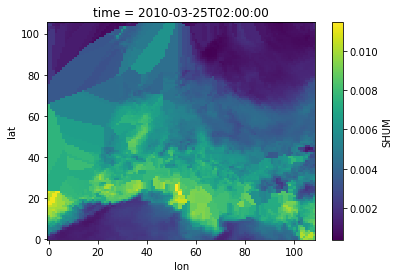

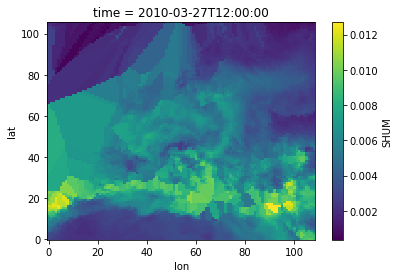

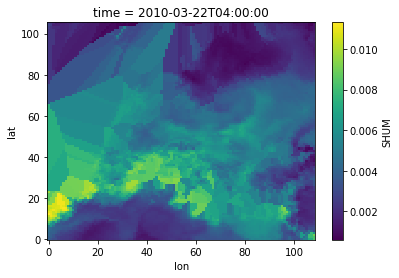

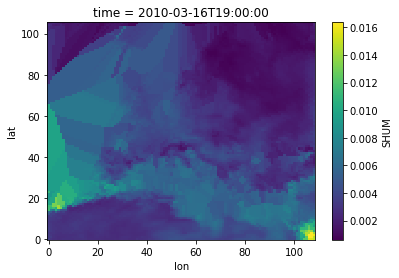

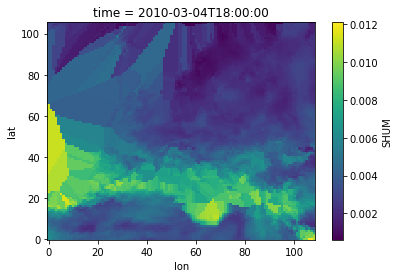

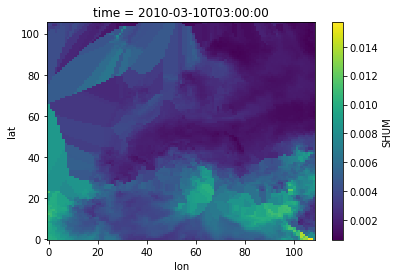

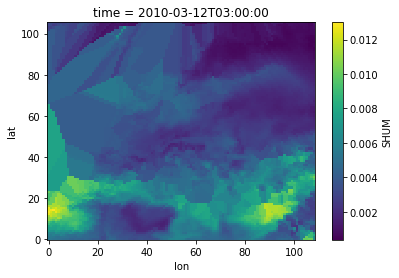

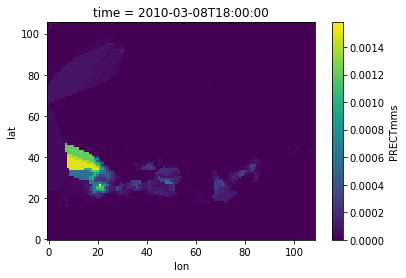

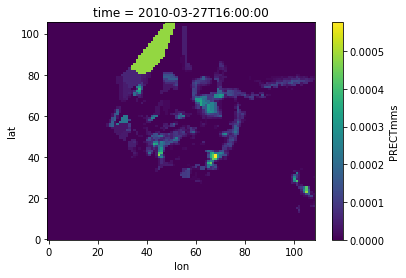

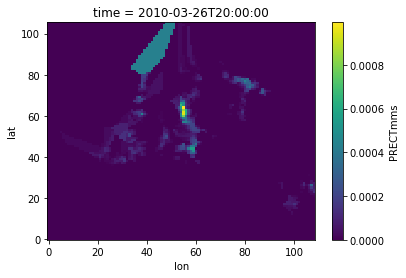

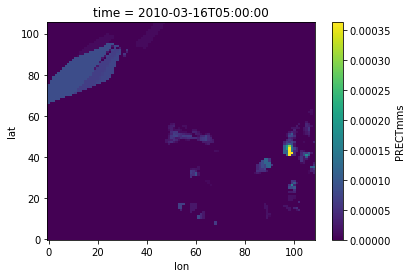

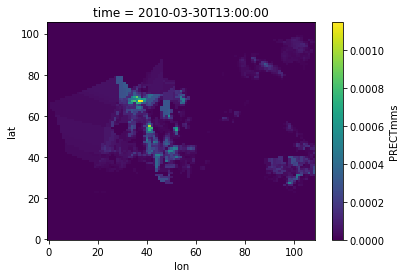

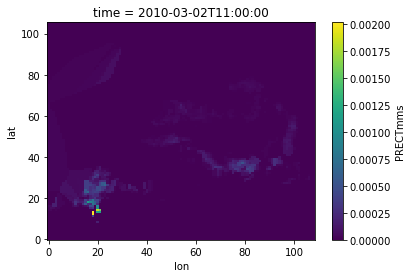

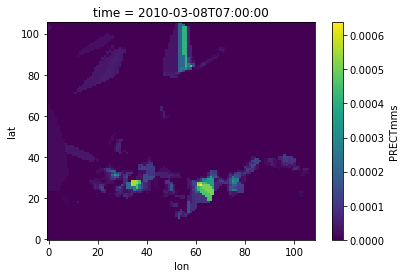

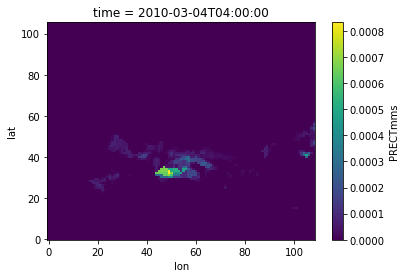

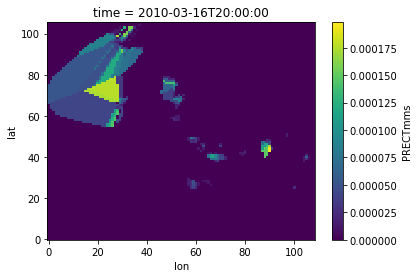

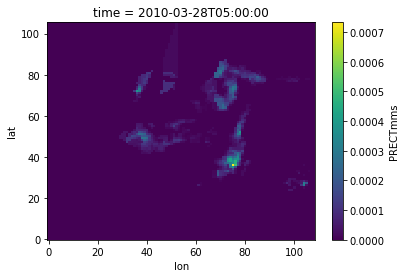

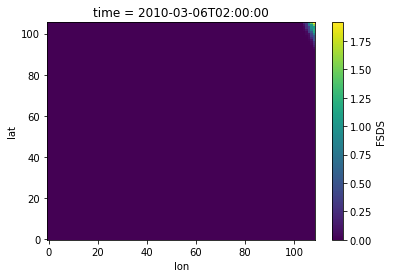

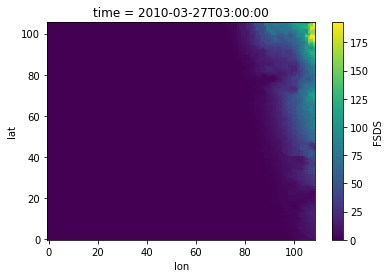

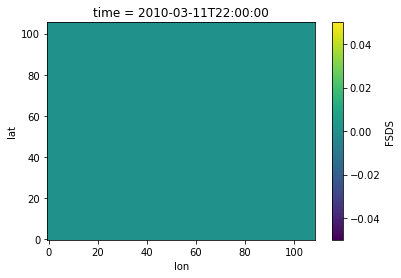

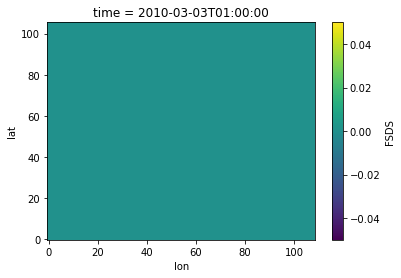

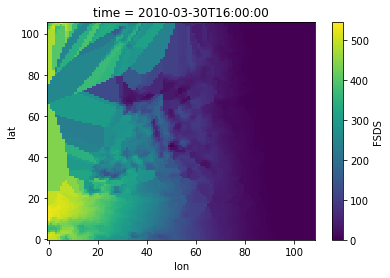

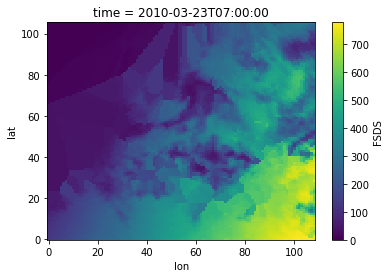

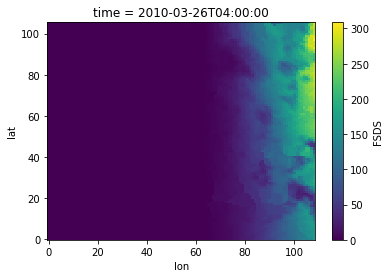

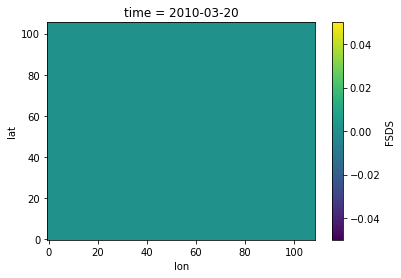

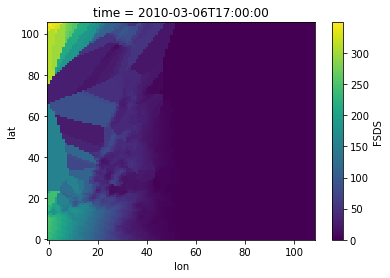

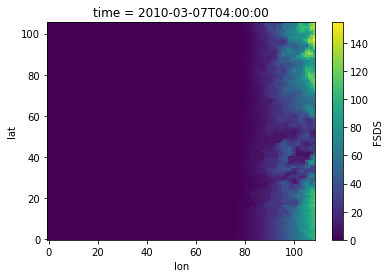

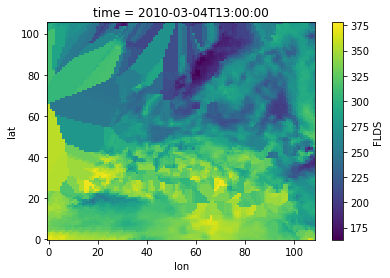

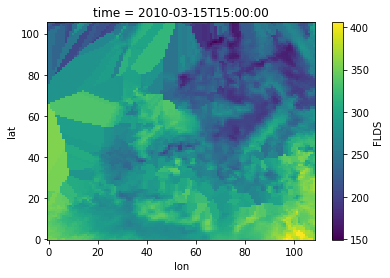

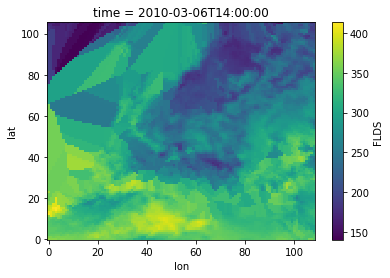

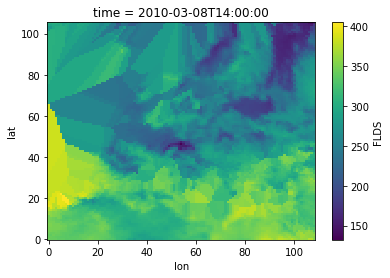

In [ ]:
vars_ = ['TBOT','PSRF','SHUM','PRECTmms','FSDS','FLDS','WIND']

for var_ in vars_:
    
    for i in np.random.randint(0,744,10):
        
        plt.figure()
        data[var_][i,:,:].plot.pcolormesh()

array([418, 715, 654, 341, 472, 286, 227, 142, 678, 619])